In [67]:
import numpy as np

class bayesianAgent(object):
    neighbors = {}

    def __init__(self):
        pass

    def update_info(self):
        pass

    def spreading_process(self):
        pass


class bayesianUpdater(object):
    def __init__(self):
        pass

    def get_all_probas(self):
        pass

    def update_all_probas(self):
        pass

class misinfoAgent(bayesianAgent):
    def __init__(
        self,
        agent_id,
        neighbors,
        forcefulness,
        share_propensity,
        misinfo_belief,
        trust_stability
    ):
        super().__init__()
        self.agent_id = agent_id
        self.neighbors = neighbors
        self.forcefulness = forcefulness
        self.share_propensity = share_propensity
        self.misinfo_belief = misinfo_belief
        self.trust_stability = trust_stability

In [264]:
from sklearn.linear_model import LinearRegression
import powerlaw

MARKOV_STEP = 0.01

def generate_params_dict():
    B1_NTRUST = np.random.choice([1, 2, 3, 4, 5])
    B2_NTRUST = np.random.choice([1, 2, 3, 4, 5])
    FORCEFULNESS_START_LOW = np.log(np.random.uniform())
    FORCEFULNESS_START_HIGH = np.log(1.0 - np.exp(FORCEFULNESS_START_LOW))
    FORCEFULNESS_WT = np.random.choice([i for i in range(1, 100)])
    SP_START_LOW = np.log(np.random.uniform())
    SP_START_HIGH = np.log(1.0 - np.exp(SP_START_LOW))
    SP_WT = np.random.choice([i for i in range(1, 100)])
    MB_START_LOW = np.log(np.random.uniform())
    MB_START_HIGH = np.log(1.0 - np.exp(MB_START_LOW))
    MB_WT = np.random.choice([i for i in range(1, 100)])
    B1_START_TS = np.random.choice([ 1, 2, 3, 4, 5])
    B2_START_TS = np.random.choice([1, 2, 3, 4, 5])
    NTRUST_THRESHOLD = np.random.uniform()
    SP_THRESHOLD = np.random.uniform()
    return {
        'B1_NTRUST': B1_NTRUST,
        'B2_NTRUST': B2_NTRUST,
        'FORCEFULNESS_START_LOW': FORCEFULNESS_START_LOW,
        'FORCEFULNESS_WT': FORCEFULNESS_WT,
        'SP_START_LOW': SP_START_LOW,
        'SP_WT': SP_WT,
        'MB_START_LOW': MB_START_LOW,
        'MB_WT': MB_WT,
        'B1_START_TS': B1_START_TS,
        'B2_START_TS': B2_START_TS,
        'NTRUST_THRESHOLD': NTRUST_THRESHOLD,
        'SP_THRESHOLD': SP_THRESHOLD,
    }

PARAMS_MAX = {
        'B1_NTRUST': 5,
        'B2_NTRUST': 5,
        'FORCEFULNESS_START_LOW': 1.0,
        'FORCEFULNESS_WT': 100,
        'SP_START_LOW': 1.0,
        'SP_WT': 100,
        'MB_START_LOW': 1.0,
        'MB_WT': 100,
        'B1_START_TS': 5,
        'B2_START_TS': 5,
        'NTRUST_THRESHOLD': 1.0,
        'SP_THRESHOLD': 1.0,
}

PARAMS_MIN = {
        'B1_NTRUST': 1,
        'B2_NTRUST': 1,
        'FORCEFULNESS_START_LOW': 0.000001,
        'FORCEFULNESS_WT': 1,
        'SP_START_LOW': 0.000001,
        'SP_WT': 1,
        'MB_START_LOW': 0.000001,
        'MB_WT': 1,
        'B1_START_TS': 1,
        'B2_START_TS': 1,
        'NTRUST_THRESHOLD': 0.00001,
        'SP_THRESHOLD': 0.000001,
}

PARAMS_STEP = {
        'B1_NTRUST': 1,
        'B2_NTRUST': 1,
        'FORCEFULNESS_START_LOW': 0.05,
        'FORCEFULNESS_WT': 1,
        'SP_START_LOW': 0.05,
        'SP_WT': 1,
        'MB_START_LOW': 0.05,
        'MB_WT': 1,
        'B1_START_TS': 1,
        'B2_START_TS': 1,
        'NTRUST_THRESHOLD': 0.05,
        'SP_THRESHOLD': 0.05,
}

def step_params_dict(params_dict):
    k = np.random.choice([k for k in params_dict.keys()])
    if k in {'NTRUST_THRESHOLD', 'SP_THRESHOLD', 'B1_NTRUST', 'B2_NTRUST', 'FORCEFULNESS_WT', 'SP_WT', 'MB_WT', 'B1_START_TS', 'B2_START_TS'}:
        if np.random.uniform() > 0.5:
            params_dict[k] = min(PARAMS_MAX[k], params_dict[k] + PARAMS_STEP[k])
        else:
            params_dict[k] = max(PARAMS_MIN[k], params_dict[k] - PARAMS_STEP[k])
    elif k[-3:] == 'LOW':
        if np.random.uniform() > 0.5:
            params_dict[k] = np.log(min(0.9999999, np.exp(params_dict[k]) + PARAMS_STEP[k]))
        else:
            params_dict[k] = np.log(max(0.0000001, np.exp(params_dict[k]) - PARAMS_STEP[k]))
    else:
        if np.random.uniform() > 0.5:
            params_dict[k] = np.log(min(0.9999999, np.exp(params_dict[k]) + PARAMS_STEP[k]))
        else:
            params_dict[k] = np.log(max(0.0000001, np.exp(params_dict[k]) - PARAMS_STEP[k])) 
    return params_dict

def calc_energy(agents, shares, time_step, tot_time_steps, centrality):
    how_much_shared_by_top_one_percent_gt = 0.95
    shared = [np.sum([v for v in shares[a.agent_id].values()]) for a in agents]
    shared_by_id = [(a.agent_id, np.sum([v for v in shares[a.agent_id].values()])) for a in agents]
    shared_by_id = sorted(shared_by_id, key=lambda b: b[0])
    shared_by_id = [s[1] for s in shared_by_id]
    reg = LinearRegression().fit(centrality, shared)
    if reg.coef_[0] > 0.0:
        more_central_more_misinfo = 1.0
    else:
        more_central_more_misinfo = 10.0
    how_much_shared_by_top_one_percent_model = np.sum(
        sorted(shared)[-int(0.01 * len(shared)):]) / (1 + np.sum(shared))
    top_misinfo_share_loss = (how_much_shared_by_top_one_percent_model - how_much_shared_by_top_one_percent_gt) ** 2.0
    was_anything_shared = np.sum(shared)
    print(was_anything_shared)
    return 5000 * top_misinfo_share_loss  - was_anything_shared + more_central_more_misinfo

def acceptance_proba(energy_curr, energy_new, time_step, tot_time_steps):
    temp = 1.0 - ((time_step - 1) / tot_time_steps)
    if energy_new + 0.0001 < energy_curr:
        return 0.95
    else:
        return np.exp((energy_new - energy_curr)/ (-1 * temp))
    
def markov_update_log(quantity, threshold, step, proba_decrease):
    rand1 = np.random.uniform()
    if rand1 > threshold:
        rand2 = np.random.uniform()
        if rand2 > proba_decrease:
            return np.log(min(0.999999999, np.exp(quantity) + step))
        else:
            return np.log(max(np.exp(quantity) - step, 0.000000001))
    else:
        return quantity
    
def update_agent_info(d):
    trust_stability = d['trust_stability']
    misinfo_belief = d['misinfo_belief']
    agent_forcefulness = d['agent_forcefulness']
    share_propensity = d['share_propensity']
    neighbor_trust = d['neighbor_trust']
    neighbor_beliefs = d['neighbor_beliefs']
    neighbor_forcefulness = d['neighbor_forcefulness']
    NTRUST_THRESHOLD = d['NTRUST_THRESHOLD']
    SP_THRESHOLD = d['SP_THRESHOLD']
    for n in neighbor_trust.keys():
        neighbor_trust[n] = markov_update_log(neighbor_trust[n], trust_stability, MARKOV_STEP, NTRUST_THRESHOLD)

    trust_belief = []
    for tup, f in zip(neighbor_beliefs, neighbor_forcefulness):
        n, b = tup
        if b > 0.5:
            trust_belief.append(np.exp(neighbor_trust[n] + f))
        else:
            trust_belief.append(-1.0 * np.exp(neighbor_trust[n] + f))

    misinfo_belief = np.log(max(0.00000000001, np.exp(misinfo_belief) + np.sum(trust_belief) -  np.exp(agent_forcefulness)))

    share_propensity = markov_update_log(share_propensity, trust_stability, MARKOV_STEP, SP_THRESHOLD)
    rand0 = np.log(np.random.uniform())
    if rand0 < (0.75 * share_propensity) + (0.25 * misinfo_belief):
        shares = True
    else:
        shares = False

    return {'neighbor_trust': neighbor_trust,
            'misinfo_belief': misinfo_belief, 
            'share_propensity': share_propensity,
            'shares': shares
    }

    
def make_agent_info_dict(agent, neighbor_beliefs, neighbor_forcefulness, params_dict):
    return {
        'trust_stability': agent.trust_stability,
        'misinfo_belief': agent.misinfo_belief,
        'share_propensity': agent.share_propensity,
        'neighbor_trust': agent.neighbors,
        'neighbor_beliefs': neighbor_beliefs,
        'neighbor_forcefulness': neighbor_forcefulness,
        'agent_forcefulness': agent.forcefulness,
        'NTRUST_THRESHOLD': params_dict['NTRUST_THRESHOLD'],
        'SP_THRESHOLD': params_dict['SP_THRESHOLD']
    }

def make_er_graph(p, N_AGENTS, agents):
    G = nx.Graph()
    for i in range(N_AGENTS):
        G.add_node(i)
        for j in range(N_AGENTS):
            draw = np.random.uniform()
            if draw < p:
                G.add_edge(i, j)
                agents[i].neighbors[j] = np.log(np.random.beta(params_dict['B1_NTRUST'], params_dict['B2_NTRUST']))
                agents[j].neighbors[i] = np.log(np.random.beta(params_dict['B1_NTRUST'], params_dict['B2_NTRUST']))
    return G, agents


def make_configuration_model_graph(N_AGENTS, alpha, agents):
    powerlaw_maker = powerlaw.Power_Law(xmin=1, discrete=True, parameters=[2.2])
    degrees = powerlaw_maker.generate_random(N_AGENTS)
    stubs = []
    if np.sum(degrees) % 2 != 0:
        degrees[-1] = degrees[-1] + 1
    for deg, node in zip(degrees, range(N_AGENTS)):
        for d in range(int(deg)):
            stubs.append('{}_{}'.format(str(node), str(deg)))
    random.shuffle(stubs)
    G = nx.Graph()
    for i, j in zip(stubs[0::2], stubs[1::2]):
        i_node = int(i.split('_')[0])
        j_node = int(j.split('_')[0])
        G.add_edge(i_node, j_node)
        agents[i_node].neighbors[j_node] = np.log(np.random.beta(params_dict['B1_NTRUST'], params_dict['B2_NTRUST']))
        agents[j_node].neighbors[i_node] = np.log(np.random.beta(params_dict['B1_NTRUST'], params_dict['B2_NTRUST']))
    for i in range(len(agents)):
        if i not in G:
            G.add_node(i)
    return G, agents


def run_agent_simulation(N_AGENTS, params_dict):
    agents = []

    for i in range(N_AGENTS):
        agent = misinfoAgent(
            agent_id=i, 
            neighbors={}, 
            forcefulness=random.choices(
                    [params_dict['FORCEFULNESS_START_LOW'], np.log(1.0 - np.exp(params_dict['FORCEFULNESS_START_LOW']))], weights=[params_dict['FORCEFULNESS_WT'], 1])[0],
            share_propensity=random.choices([params_dict['SP_START_LOW'], np.log(1.0 - np.exp(params_dict['SP_START_LOW']))], weights=[params_dict['SP_WT'], 1])[0],
            misinfo_belief=random.choices([params_dict['MB_START_LOW'], np.log(1.0 - np.exp(params_dict['MB_START_LOW']))], weights=[params_dict['MB_WT'], 1])[0], 
            trust_stability=np.log(
                np.random.beta(params_dict['B1_START_TS'], params_dict['B2_START_TS'])),
        )
        agents.append(agent)

    # G, agents = make_er_graph(0.05, N_AGENTS, agents)
    G, agents = make_configuration_model_graph(N_AGENTS, 2.5, agents)
    centrality = sorted([(k, v) for k, v in nx.eigenvector_centrality(G).items()], key=lambda b: b[0])

    centrality = np.array([c[1] for c in centrality]).reshape(-1, 1)
    agent_records = {a.agent_id: {} for a in agents}
    shares = {a.agent_id: {} for a in agents}

    # from multiprocessing import Pool
    # pool = Pool(8)

    for time_step in range(100):
        for agent in agents:     
            agent_records[agent.agent_id][time_step] = {
                'neighbor_trust': agent.neighbors,
                'misinfo_belief': agent.misinfo_belief,
                'share_propensity': agent.share_propensity
            }

        neighbor_beliefs = [[(i, agents[i].misinfo_belief) for i in agent.neighbors.keys()] for agent in agents]
        neighbor_forcefulness = [[agents[i].forcefulness for i in agent.neighbors.keys()] for agent in agents]
        agent_info_dicts = [make_agent_info_dict(a, b, f, params_dict) for a, b, f in zip(agents, neighbor_beliefs, neighbor_forcefulness)]
        res = map(update_agent_info, agent_info_dicts)
        for r, agent in zip(res, agents):
            agent.neighbors = r['neighbor_trust']
            agent.misinfo_belief = r['misinfo_belief']
            agent.share_propensity = r['share_propensity']
            shares[agent.agent_id][time_step] = r['shares']
            
    return agents, shares, centrality

In [265]:
import random
import time
import networkx as nx

energy_curr = 10000
SA_STEPS = 250
params_dict_old = generate_params_dict()

for sa_step in range(SA_STEPS):
    print(energy_curr)
    params_dict = step_params_dict(params_dict_old)

    N_AGENTS = 100
    try:
        agents, shares, centrality = run_agent_simulation(N_AGENTS, params_dict)
    except Exception as e:
        print(e)
        continue
    energy_new = calc_energy(agents, shares, sa_step, SA_STEPS, centrality)
    print(sa_step)
    print('curr: ', energy_curr, ' new: ', energy_new)
    acceptance = acceptance_proba(energy_curr, energy_new, sa_step, SA_STEPS)
    print('acceptance: ', acceptance)
    if np.random.uniform() < acceptance:
        params_dict_old = params_dict
        energy_curr = energy_new
        print('changed')
    # print(params_dict)
    print(params_dict_old)
    print()


10000
10
0
curr:  10000  new:  3690.185950413222
acceptance:  0.95
changed
{'B1_NTRUST': 3, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.509655171858179, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.8650559837618441, 'SP_WT': 90, 'MB_START_LOW': -0.4919907031274439, 'MB_WT': 51, 'B1_START_TS': 4, 'B2_START_TS': 4, 'NTRUST_THRESHOLD': 0.12140352397818865, 'SP_THRESHOLD': 0.6433613979757772}

3690.185950413222
2
1
curr:  3690.185950413222  new:  1900.3888888888891
acceptance:  0.95
changed
{'B1_NTRUST': 3, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.4297024503252849, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.8650559837618441, 'SP_WT': 90, 'MB_START_LOW': -0.4919907031274439, 'MB_WT': 51, 'B1_START_TS': 4, 'B2_START_TS': 4, 'NTRUST_THRESHOLD': 0.12140352397818865, 'SP_THRESHOLD': 0.6433613979757772}

1900.3888888888891
9
2
curr:  1900.3888888888891  new:  2804.5
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.4297024503252849, 'FORCEFULNESS_WT': 5, 'SP_START_LOW

5
21
curr:  1518.4999999999998  new:  3073.0555555555557
acceptance:  0.0
{'B1_NTRUST': 4, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.4297024503252849, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.8650559837618441, 'SP_WT': 90, 'MB_START_LOW': -0.5773072760251561, 'MB_WT': 53, 'B1_START_TS': 5, 'B2_START_TS': 4, 'NTRUST_THRESHOLD': 0.07140352397818865, 'SP_THRESHOLD': 0.5933613979757771}

1518.4999999999998
11
22
curr:  1518.4999999999998  new:  3754.5555555555547
acceptance:  0.0
{'B1_NTRUST': 4, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.4297024503252849, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.8650559837618441, 'SP_WT': 90, 'MB_START_LOW': -0.5773072760251561, 'MB_WT': 52, 'B1_START_TS': 5, 'B2_START_TS': 4, 'NTRUST_THRESHOLD': 0.07140352397818865, 'SP_THRESHOLD': 0.5933613979757771}

1518.4999999999998
10
23
curr:  1518.4999999999998  new:  3690.185950413222
acceptance:  0.0
{'B1_NTRUST': 4, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.4297024503252849, 'FORCEFULNESS_WT': 4, 'SP_S

7
42
curr:  1518.4999999999998  new:  3406.1249999999995
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 1, 'FORCEFULNESS_START_LOW': -0.10458006218823454, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.7528377785832041, 'SP_WT': 90, 'MB_START_LOW': -0.6705874751681687, 'MB_WT': 52, 'B1_START_TS': 4, 'B2_START_TS': 1, 'NTRUST_THRESHOLD': 0.07140352397818865, 'SP_THRESHOLD': 0.5433613979757771}

1518.4999999999998
14
43
curr:  1518.4999999999998  new:  3330.722222222222
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 1, 'FORCEFULNESS_START_LOW': -0.10458006218823454, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.7528377785832041, 'SP_WT': 90, 'MB_START_LOW': -0.6705874751681687, 'MB_WT': 52, 'B1_START_TS': 5, 'B2_START_TS': 1, 'NTRUST_THRESHOLD': 0.07140352397818865, 'SP_THRESHOLD': 0.5433613979757771}

1518.4999999999998
13
44
curr:  1518.4999999999998  new:  3254.3979591836737
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 1, 'FORCEFULNESS_START_LOW': -0.10458006218823454, 'FORCEFULNESS_WT': 4, 'S

11
64
curr:  1518.4999999999998  new:  3058.0555555555557
acceptance:  0.0
{'B1_NTRUST': 5, 'B2_NTRUST': 1, 'FORCEFULNESS_START_LOW': -0.10458006218823454, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.7528377785832041, 'SP_WT': 90, 'MB_START_LOW': -0.7734724865184183, 'MB_WT': 51, 'B1_START_TS': 5, 'B2_START_TS': 2, 'NTRUST_THRESHOLD': 0.12140352397818865, 'SP_THRESHOLD': 0.4433613979757771}

1518.4999999999998
13
65
curr:  1518.4999999999998  new:  3856.438775510204
acceptance:  0.0
{'B1_NTRUST': 5, 'B2_NTRUST': 1, 'FORCEFULNESS_START_LOW': -0.10458006218823454, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.7528377785832041, 'SP_WT': 90, 'MB_START_LOW': -0.7734724865184183, 'MB_WT': 51, 'B1_START_TS': 5, 'B2_START_TS': 2, 'NTRUST_THRESHOLD': 0.12140352397818865, 'SP_THRESHOLD': 0.4433613979757771}

1518.4999999999998
7
66
curr:  1518.4999999999998  new:  3406.1249999999995
acceptance:  0.0
{'B1_NTRUST': 5, 'B2_NTRUST': 1, 'FORCEFULNESS_START_LOW': -0.10458006218823454, 'FORCEFULNESS_WT': 4, 'S

23
84
curr:  1518.4999999999998  new:  3733.5555555555547
acceptance:  0.0
{'B1_NTRUST': 5, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.10458006218823454, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.6519515318815069, 'SP_WT': 89, 'MB_START_LOW': -0.7734724865184183, 'MB_WT': 52, 'B1_START_TS': 5, 'B2_START_TS': 3, 'NTRUST_THRESHOLD': 0.17140352397818864, 'SP_THRESHOLD': 0.19336139797577717}

1518.4999999999998
15
85
curr:  1518.4999999999998  new:  2902.0312499999995
acceptance:  0.0
{'B1_NTRUST': 5, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.10458006218823454, 'FORCEFULNESS_WT': 6, 'SP_START_LOW': -0.6519515318815069, 'SP_WT': 89, 'MB_START_LOW': -0.7734724865184183, 'MB_WT': 52, 'B1_START_TS': 5, 'B2_START_TS': 3, 'NTRUST_THRESHOLD': 0.17140352397818864, 'SP_THRESHOLD': 0.19336139797577717}

1518.4999999999998
17
86
curr:  1518.4999999999998  new:  3984.154320987654
acceptance:  0.0
{'B1_NTRUST': 5, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.10458006218823454, 'FORCEFULNESS_WT': 6,

15
105
curr:  1518.4999999999998  new:  3933.2812499999995
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 1, 'FORCEFULNESS_START_LOW': -0.10458006218823454, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.7528377785832041, 'SP_WT': 89, 'MB_START_LOW': -1.017747626615228, 'MB_WT': 52, 'B1_START_TS': 5, 'B2_START_TS': 2, 'NTRUST_THRESHOLD': 0.3214035239781886, 'SP_THRESHOLD': 0.29336139797577715}

1518.4999999999998
15
106
curr:  1518.4999999999998  new:  3389.1249999999995
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 1, 'FORCEFULNESS_START_LOW': -0.050553902234383954, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.7528377785832041, 'SP_WT': 89, 'MB_START_LOW': -1.017747626615228, 'MB_WT': 52, 'B1_START_TS': 5, 'B2_START_TS': 2, 'NTRUST_THRESHOLD': 0.3214035239781886, 'SP_THRESHOLD': 0.29336139797577715}

1518.4999999999998
13
107
curr:  1518.4999999999998  new:  3254.3979591836737
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 1, 'FORCEFULNESS_START_LOW': -0.050553902234383954, 'FORCEFULNESS_WT': 

12
125
curr:  1518.4999999999998  new:  3167.3047337278103
acceptance:  0.0
{'B1_NTRUST': 2, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.050553902234383954, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.9914777980939652, 'SP_WT': 87, 'MB_START_LOW': -1.1666511689571317, 'MB_WT': 52, 'B1_START_TS': 3, 'B2_START_TS': 2, 'NTRUST_THRESHOLD': 0.2714035239781886, 'SP_THRESHOLD': 0.34336139797577714}

1518.4999999999998
9
126
curr:  1518.4999999999998  new:  2813.5
acceptance:  0.0
{'B1_NTRUST': 2, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.050553902234383954, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.9914777980939652, 'SP_WT': 86, 'MB_START_LOW': -1.1666511689571317, 'MB_WT': 52, 'B1_START_TS': 3, 'B2_START_TS': 2, 'NTRUST_THRESHOLD': 0.2714035239781886, 'SP_THRESHOLD': 0.34336139797577714}

1518.4999999999998
5
127
curr:  1518.4999999999998  new:  3073.0555555555557
acceptance:  0.0
{'B1_NTRUST': 2, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.050553902234383954, 'FORCEFULNESS_WT': 5, 'SP_STAR

193
145
curr:  21.267578124999943  new:  1902.7809012647458
acceptance:  0.0
{'B1_NTRUST': 1, 'B2_NTRUST': 3, 'FORCEFULNESS_START_LOW': -1.0000000494736474e-07, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.8650559837618441, 'SP_WT': 88, 'MB_START_LOW': -1.0177476266152283, 'MB_WT': 53, 'B1_START_TS': 2, 'B2_START_TS': 4, 'NTRUST_THRESHOLD': 0.17140352397818864, 'SP_THRESHOLD': 0.29336139797577715}

21.267578124999943
145
146
curr:  21.267578124999943  new:  1354.9817038844055
acceptance:  0.0
{'B1_NTRUST': 1, 'B2_NTRUST': 3, 'FORCEFULNESS_START_LOW': -1.0000000494736474e-07, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.8650559837618441, 'SP_WT': 88, 'MB_START_LOW': -1.0177476266152283, 'MB_WT': 53, 'B1_START_TS': 2, 'B2_START_TS': 4, 'NTRUST_THRESHOLD': 0.17140352397818864, 'SP_THRESHOLD': 0.29336139797577715}

21.267578124999943
190
147
curr:  21.267578124999943  new:  1742.9739453414104
acceptance:  0.0
{'B1_NTRUST': 1, 'B2_NTRUST': 3, 'FORCEFULNESS_START_LOW': -1.0000000494736474e-07, 'FORC

12
165
curr:  21.267578124999943  new:  3158.3047337278103
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 5, 'FORCEFULNESS_START_LOW': -1.0000000494736474e-07, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.7528377785832041, 'SP_WT': 89, 'MB_START_LOW': -1.166651168957132, 'MB_WT': 52, 'B1_START_TS': 3, 'B2_START_TS': 5, 'NTRUST_THRESHOLD': 0.17140352397818864, 'SP_THRESHOLD': 0.24336139797577716}

21.267578124999943
16
166
curr:  21.267578124999943  new:  3458.0570934256048
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 5, 'FORCEFULNESS_START_LOW': -1.0000000494736474e-07, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.7528377785832041, 'SP_WT': 89, 'MB_START_LOW': -1.166651168957132, 'MB_WT': 52, 'B1_START_TS': 3, 'B2_START_TS': 5, 'NTRUST_THRESHOLD': 0.17140352397818864, 'SP_THRESHOLD': 0.24336139797577716}

21.267578124999943
21
167
curr:  21.267578124999943  new:  3679.185950413222
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 5, 'FORCEFULNESS_START_LOW': -1.0000000494736474e-07, 'FORCEFULNE

261
185
curr:  -17.27777777777787  new:  2106.380834450207
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 5, 'FORCEFULNESS_START_LOW': -1.0000000494736474e-07, 'FORCEFULNESS_WT': 3, 'SP_START_LOW': -0.6519515318815069, 'SP_WT': 89, 'MB_START_LOW': -1.0177476266152283, 'MB_WT': 53, 'B1_START_TS': 5, 'B2_START_TS': 5, 'NTRUST_THRESHOLD': 0.22140352397818863, 'SP_THRESHOLD': 0.19336139797577717}

-17.27777777777787
131
186
curr:  -17.27777777777787  new:  925.8778696051422
acceptance:  0.0
{'B1_NTRUST': 3, 'B2_NTRUST': 4, 'FORCEFULNESS_START_LOW': -1.0000000494736474e-07, 'FORCEFULNESS_WT': 3, 'SP_START_LOW': -0.6519515318815069, 'SP_WT': 89, 'MB_START_LOW': -1.0177476266152283, 'MB_WT': 53, 'B1_START_TS': 5, 'B2_START_TS': 5, 'NTRUST_THRESHOLD': 0.22140352397818863, 'SP_THRESHOLD': 0.19336139797577717}

-17.27777777777787
354
187
curr:  -17.27777777777787  new:  2447.412914104344
acceptance:  0.0
{'B1_NTRUST': 2, 'B2_NTRUST': 4, 'FORCEFULNESS_START_LOW': -1.0000000494736474e-07, 'FORCEFU

15
205
curr:  -17.27777777777787  new:  3389.1249999999995
acceptance:  0.0
{'B1_NTRUST': 2, 'B2_NTRUST': 4, 'FORCEFULNESS_START_LOW': -0.10536062676894363, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.6519515318815069, 'SP_WT': 90, 'MB_START_LOW': -1.166651168957132, 'MB_WT': 52, 'B1_START_TS': 5, 'B2_START_TS': 4, 'NTRUST_THRESHOLD': 0.17140352397818864, 'SP_THRESHOLD': 0.24336139797577716}

-17.27777777777787
22
206
curr:  -17.27777777777787  new:  3703.2202268431
acceptance:  0.0
{'B1_NTRUST': 2, 'B2_NTRUST': 4, 'FORCEFULNESS_START_LOW': -0.10536062676894363, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.6519515318815069, 'SP_WT': 90, 'MB_START_LOW': -1.166651168957132, 'MB_WT': 52, 'B1_START_TS': 5, 'B2_START_TS': 4, 'NTRUST_THRESHOLD': 0.17140352397818864, 'SP_THRESHOLD': 0.19336139797577717}

-17.27777777777787
9
207
curr:  -17.27777777777787  new:  3613.4999999999995
acceptance:  0.0
{'B1_NTRUST': 2, 'B2_NTRUST': 3, 'FORCEFULNESS_START_LOW': -0.10536062676894363, 'FORCEFULNESS_WT': 4, '

17
225
curr:  -17.27777777777787  new:  3511.6728395061723
acceptance:  0.0
{'B1_NTRUST': 2, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.16251904714484075, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.6519515318815069, 'SP_WT': 91, 'MB_START_LOW': -1.166651168957132, 'MB_WT': 51, 'B1_START_TS': 4, 'B2_START_TS': 4, 'NTRUST_THRESHOLD': 0.22140352397818863, 'SP_THRESHOLD': 0.24336139797577716}

-17.27777777777787
10
226
curr:  -17.27777777777787  new:  2950.5165289256192
acceptance:  0.0
{'B1_NTRUST': 2, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.16251904714484075, 'FORCEFULNESS_WT': 4, 'SP_START_LOW': -0.6519515318815069, 'SP_WT': 91, 'MB_START_LOW': -1.166651168957132, 'MB_WT': 51, 'B1_START_TS': 5, 'B2_START_TS': 4, 'NTRUST_THRESHOLD': 0.22140352397818863, 'SP_THRESHOLD': 0.24336139797577716}

-17.27777777777787
17
227
curr:  -17.27777777777787  new:  3502.6728395061723
acceptance:  0.0
{'B1_NTRUST': 2, 'B2_NTRUST': 2, 'FORCEFULNESS_START_LOW': -0.16251904714484075, 'FORCEFULNESS_WT': 

19
245
curr:  -17.27777777777787  new:  4040.999999999999
acceptance:  0.0
{'B1_NTRUST': 1, 'B2_NTRUST': 3, 'FORCEFULNESS_START_LOW': -0.16251904714484075, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.8650559837618441, 'SP_WT': 90, 'MB_START_LOW': -1.5539651268542258, 'MB_WT': 51, 'B1_START_TS': 4, 'B2_START_TS': 5, 'NTRUST_THRESHOLD': 0.17140352397818864, 'SP_THRESHOLD': 0.19336139797577717}

-17.27777777777787
18
246
curr:  -17.27777777777787  new:  3559.901662049861
acceptance:  0.0
{'B1_NTRUST': 1, 'B2_NTRUST': 3, 'FORCEFULNESS_START_LOW': -0.16251904714484075, 'FORCEFULNESS_WT': 5, 'SP_START_LOW': -0.8650559837618441, 'SP_WT': 90, 'MB_START_LOW': -1.5539651268542258, 'MB_WT': 51, 'B1_START_TS': 4, 'B2_START_TS': 5, 'NTRUST_THRESHOLD': 0.17140352397818864, 'SP_THRESHOLD': 0.24336139797577716}

-17.27777777777787
13
247
curr:  -17.27777777777787  new:  2694.3775510204073
acceptance:  0.0
{'B1_NTRUST': 1, 'B2_NTRUST': 3, 'FORCEFULNESS_START_LOW': -0.16251904714484075, 'FORCEFULNESS_WT': 

(array([90.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

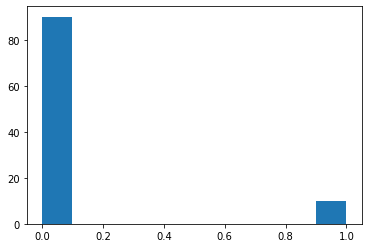

In [266]:
import matplotlib.pyplot as plt
agents, shares, centrality = run_agent_simulation(N_AGENTS, params_dict)

share_counts = [np.sum([v for v in v.values()]) for v in shares.values()]
plt.hist(share_counts)

In [4]:
import scipy.stats
lower = 0
upper = 1
mu = 0.5
sigma = 0.1
N = 100000

def truncated_normal():
    return scipy.stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma)